In [1]:
import os
from multiprocessing import Pool
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from midi_util import read_midi, produce_song, mute

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
path = os.getcwd() + "/data/"
print("Data path: ", path)

midi_file_paths = [path + i for i in os.listdir(path) if i.endswith(".mid")]
print("# of Files Found: ", len(midi_file_paths))

with Pool(processes=6, initializer=mute) as p: # send excessive output to devnull
    note_objects_by_file, note_strings_by_file = zip(*p.map(read_midi, midi_file_paths))

Data path:  /Users/danielrjohnson/Documents/OneDrive/Programming/AIO/Music-Generation/data/
# of Files Found:  75
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
#list comp to flatten
flattened_note_strings = [element for note_ in note_strings_by_file for element in note_]
flattened_note_objects = [element for note_ in note_objects_by_file for element in note_]
print("# of Notes Total: ", len(flattened_note_strings))

all_unique_notes = list(set(flattened_note_strings))
print("# of Unique Notes: ", len(all_unique_notes))

# of Notes Total:  56365
# of Unique Notes:  101


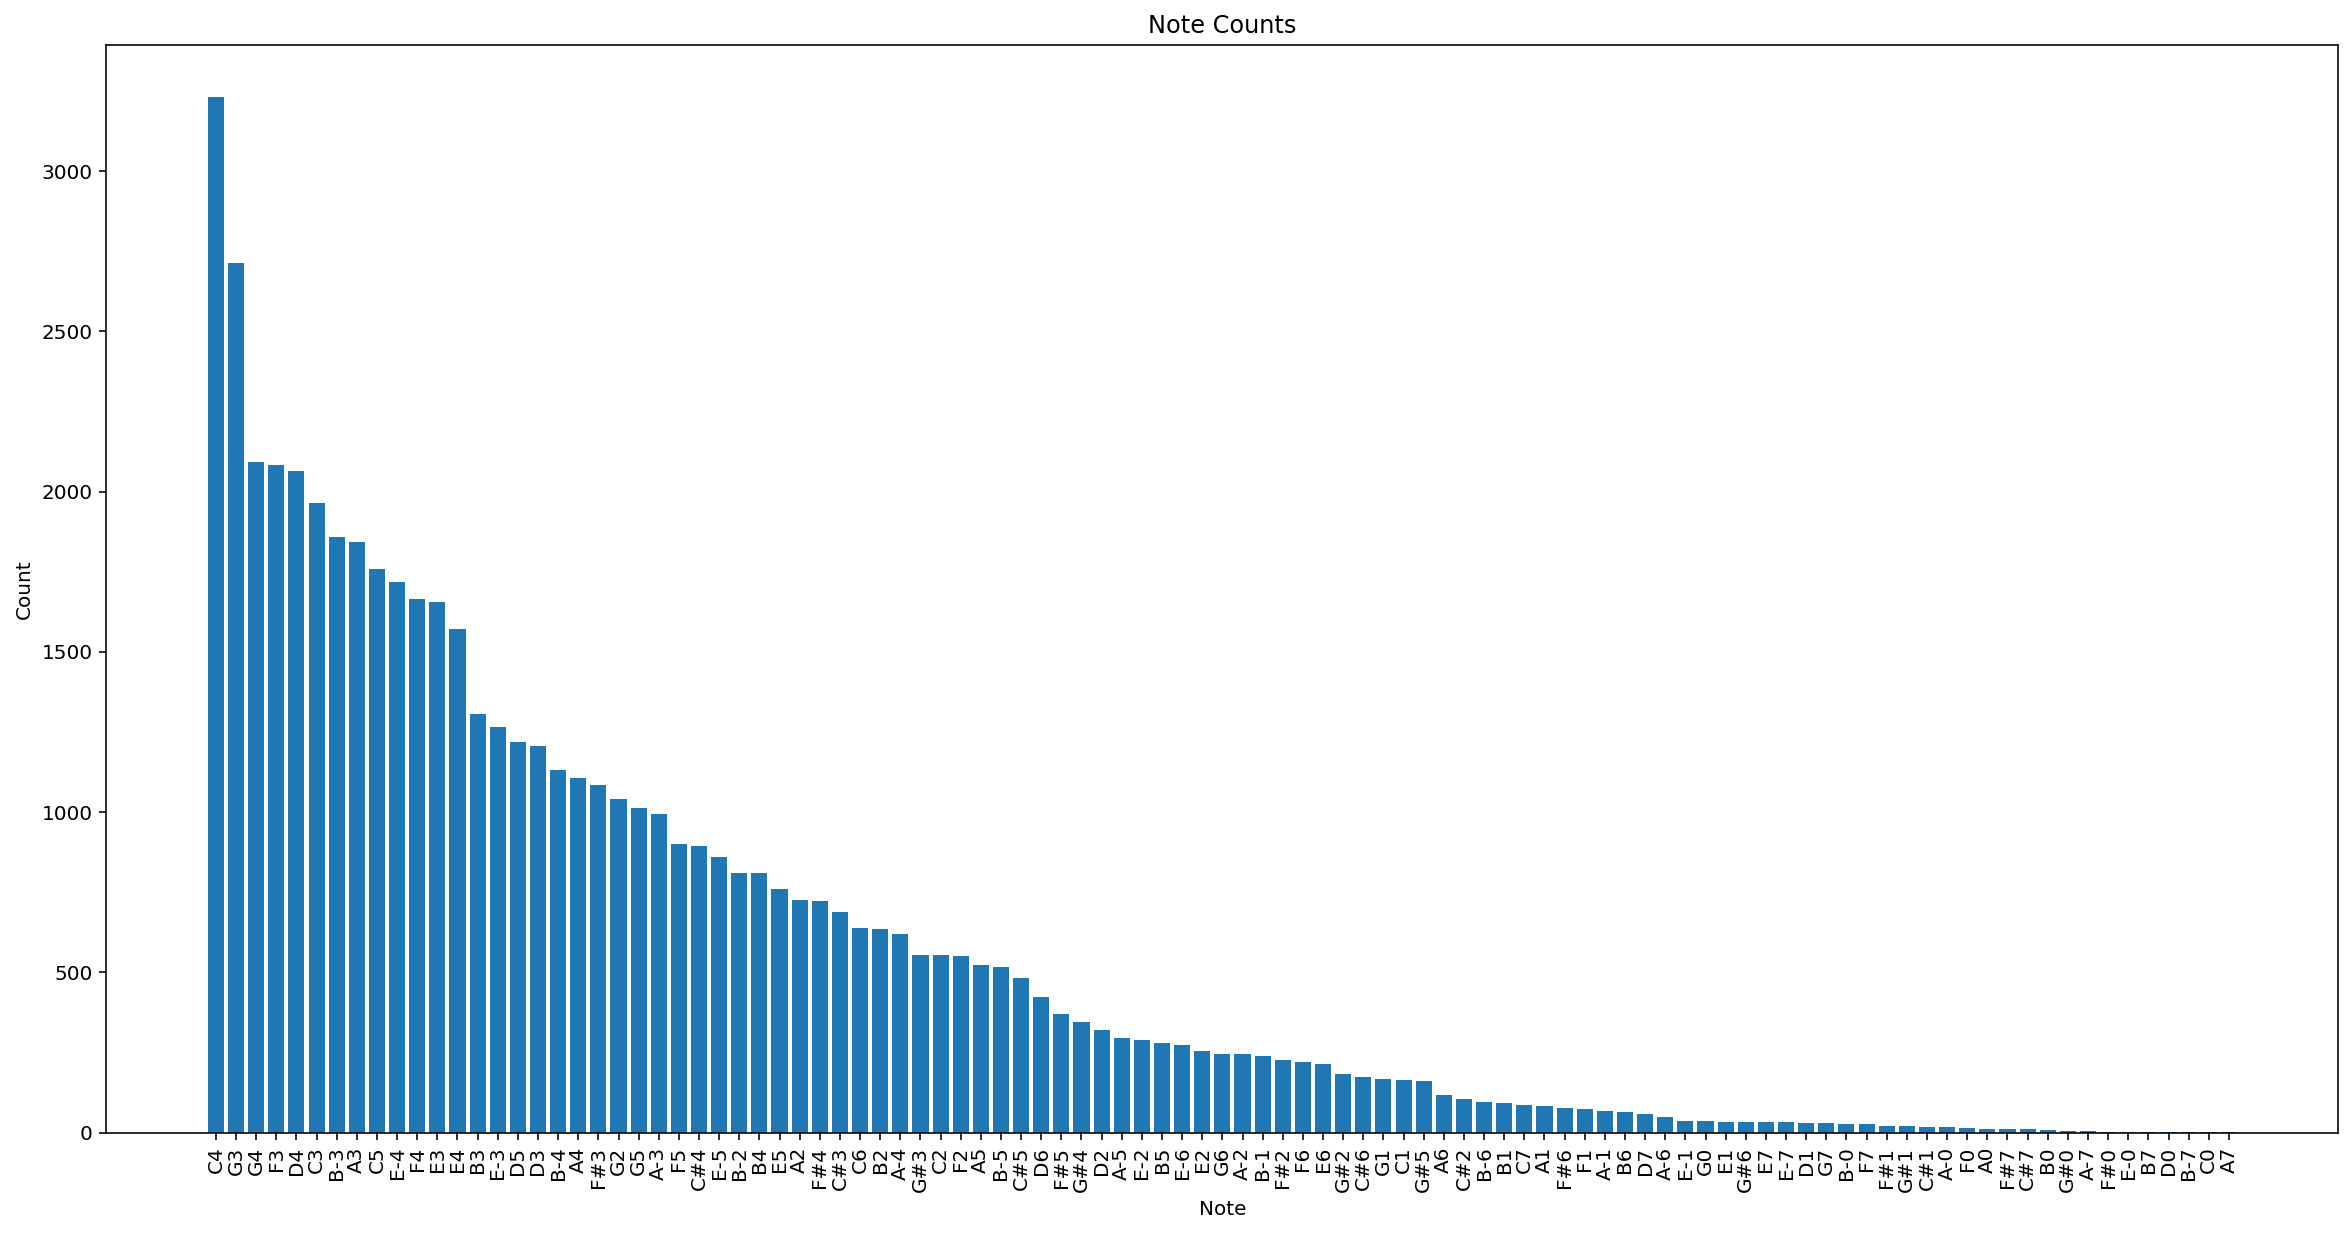

In [4]:
note_counts = dict(Counter(flattened_note_strings))

decending_note_counts = sorted(note_counts.items(), key=lambda x: x[1], reverse=True)
plt.figure(figsize=(20,10))
plt.bar(range(len(decending_note_counts)), [i[1] for i in decending_note_counts])
plt.xticks(range(len(decending_note_counts)), [i[0] for i in decending_note_counts], rotation=90)
plt.title("Note Counts")
plt.xlabel("Note")
plt.ylabel("Count")
plt.show()

In [5]:
MIN_COUNT = 500
frequent_note_strings = [note_ for note_, count in note_counts.items() if count >= MIN_COUNT]
print("# of Notes Occurring At Least", MIN_COUNT, "Times: ", len(frequent_note_strings))

# of Notes Occurring At Least 500 Times:  40


In [6]:
freq_note_strings = [note_ for note_ in flattened_note_strings if note_ in frequent_note_strings]
freq_durations = [note_.duration.type for note_ in flattened_note_objects if str(note_.pitch) in frequent_note_strings]

freq_note_strings = np.array(freq_note_strings)
freq_durations = np.array(freq_durations)

print("Flattened Frequent Notes & Durations Shapes:")
print(freq_note_strings.shape)
print(freq_durations.shape)

Flattened Frequent Notes & Durations Shapes:
(49356,)
(49356,)


In [7]:
n_timesteps = 8
X_note, X_dur, y_note, y_dur = [], [], [], []

for i in range(0, len(freq_note_strings) - n_timesteps):
    X_note.append([freq_note_strings[i: i + n_timesteps]])
    X_dur.append([freq_durations[i: i + n_timesteps]])
    y_note.append([freq_note_strings[i + n_timesteps]])
    y_dur.append([freq_durations[i + n_timesteps]])

X_note = np.array(X_note).reshape(-1, n_timesteps, 1)
X_dur = np.array(X_dur).reshape(-1, n_timesteps, 1)
y_note = np.array(y_note)
y_dur = np.array(y_dur)

print(X_note.shape, X_dur.shape, y_note.shape, y_dur.shape)

(49348, 8, 1) (49348, 8, 1) (49348, 1) (49348, 1)


In [8]:
print(np.unique(y_note))
print(len(np.unique(y_note)))

['A-3' 'A-4' 'A2' 'A3' 'A4' 'A5' 'B-2' 'B-3' 'B-4' 'B-5' 'B2' 'B3' 'B4'
 'C#3' 'C#4' 'C2' 'C3' 'C4' 'C5' 'C6' 'D3' 'D4' 'D5' 'E-3' 'E-4' 'E-5'
 'E3' 'E4' 'E5' 'F#3' 'F#4' 'F2' 'F3' 'F4' 'F5' 'G#3' 'G2' 'G3' 'G4' 'G5']
40


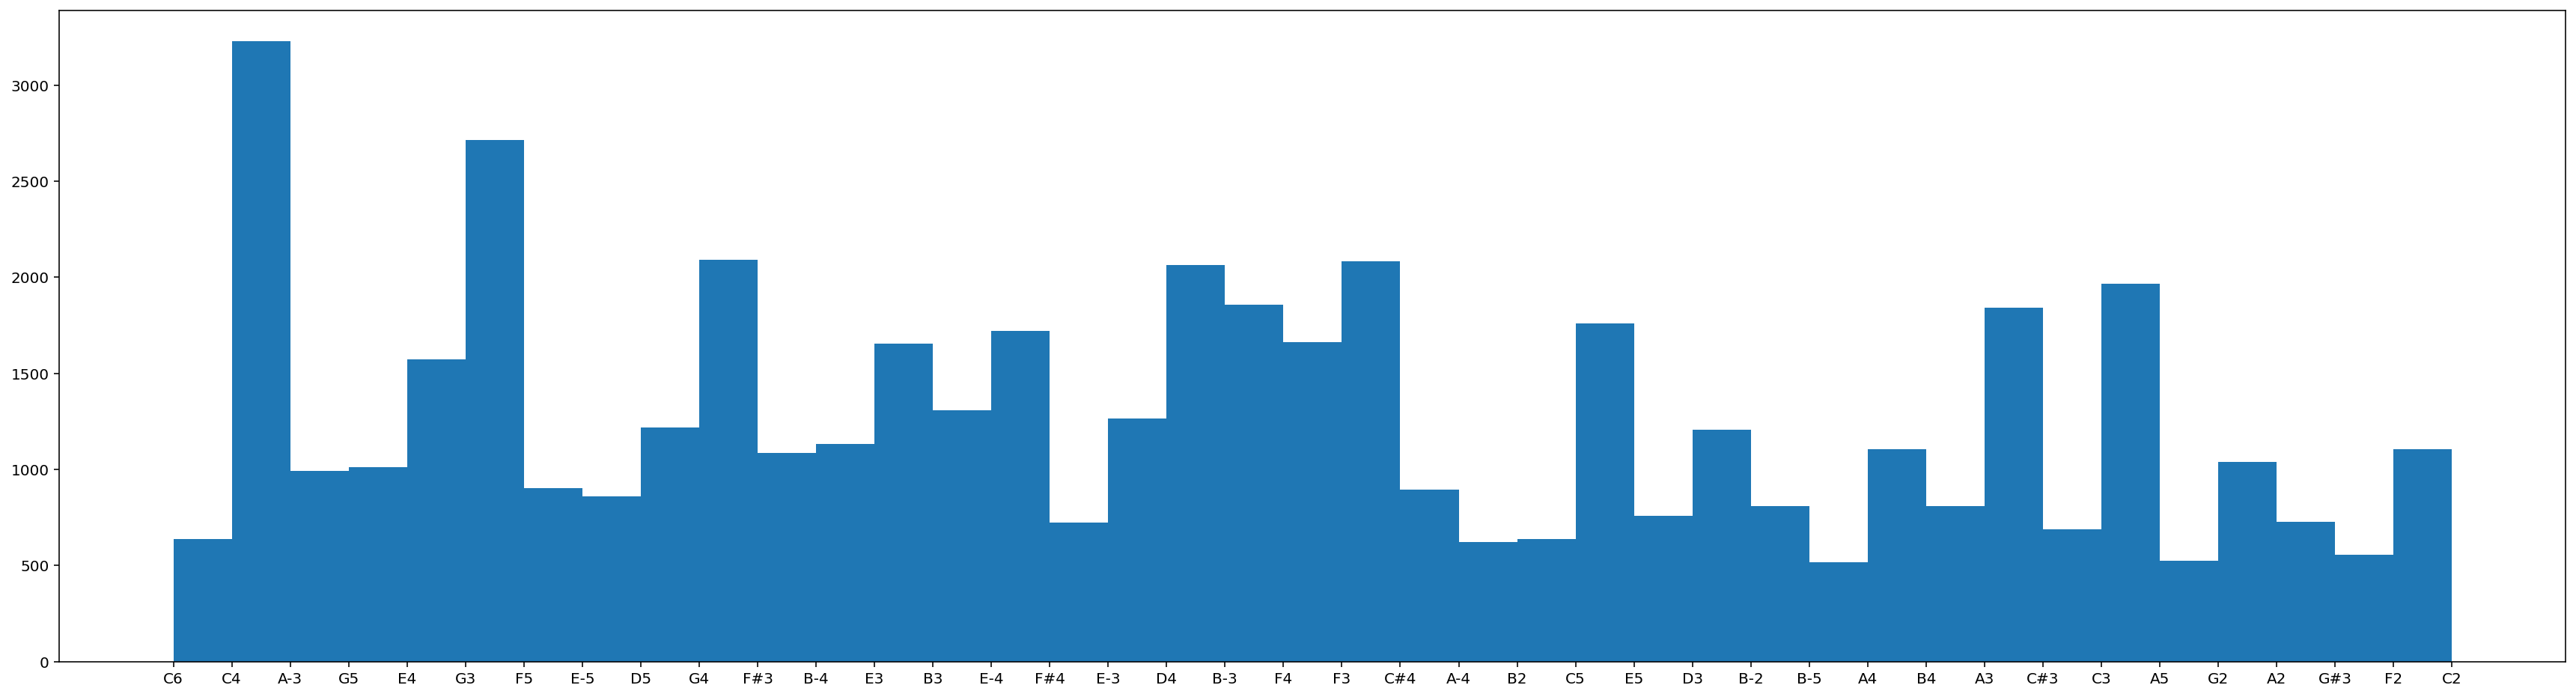

In [9]:
# make the figsize a bigger
plt.figure(figsize=(30, 8))
plt.hist(y_note, bins=np.arange(0, len(np.unique(y_note)), 1))
plt.show()

In [10]:
note_to_int = {note: number for number, note in enumerate(np.unique(freq_note_strings))}
dur_to_int = {note: number for number, note in enumerate(np.unique(freq_durations))}

int_to_note = {int_: note for note, int_ in note_to_int.items()}
int_to_dur = {int_: dur for dur, int_ in dur_to_int.items()}

X_note_enc = np.array([[note_to_int[note[0]] for note in note_sequence] for note_sequence in X_note])
X_dur_enc = np.array([[dur_to_int[dur[0]] for dur in dur_sequence] for dur_sequence in X_dur])
y_note_enc = np.array([[note_to_int[note] for note in note_sequence] for note_sequence in y_note])
y_dur_enc = np.array([[dur_to_int[dur] for dur in dur_sequence] for dur_sequence in y_dur])


# unique_x_note = list(set(X[:, 0].ravel()))
# x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x_note))
# x_seq_note = np.array([[x_note_to_int[note] for note in row] for row in X[:, 0]])

# unique_x_dur = list(set(X[:, 1].ravel()))
# x_dur_to_int = dict((duration, number) for number, duration in enumerate(unique_x_dur))
# x_seq_dur = np.array([[x_dur_to_int[duration] for duration in row] for row in X[:, 1]])

# # ([Nx32x1], [Nx32x1]) -> ([Nx32x2])
# x_seq_combined = np.array(
#     [ [ [note, duration] for note, duration in zip(row_note, row_dur) ]
#         for row_note, row_dur in zip(x_seq_note, x_seq_dur) ]
# )
# print("combined note and duration array shape:", x_seq_combined.shape)

# unique_y_note = list(set(y_note))
# y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y_note)) 
# y_seq_note = np.array([y_note_to_int[note] for note in y_note], dtype=float)

# unique_y_duration = list(set(y_duration))
# y_dur_to_int = dict((duration_, number) for number, duration_ in enumerate(unique_y_duration))
# y_seq_dur = np.array([y_dur_to_int[duration] for duration in y_duration], dtype=float)

In [11]:
x_tr_note, x_val_note, y_tr_note, y_val_note = train_test_split(X_note_enc, y_note_enc, test_size=0.2, random_state=0)
x_tr_dur, x_val_dur, y_tr_dur, y_val_dur = train_test_split(X_dur_enc, y_dur_enc, test_size=0.2, random_state=0)
print("x_tr_note shape:", x_tr_note.shape, "y_tr_note shape:", y_tr_note.shape)

x_tr_note shape: (39478, 8) y_tr_note shape: (39478, 1)


In [12]:
inputs = Input((n_timesteps, 1))
x = Dense(128, activation="relu")(inputs)
x = LSTM(128)(x)
x = Dense(128, activation="relu")(x)
output = Dense(len(np.unique(freq_note_strings)), activation="softmax")(x)

model_note = tf.keras.Model(inputs, output)

model_note.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model_note.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 1)]            0         
_________________________________________________________________
dense (Dense)                (None, 8, 128)            256       
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                5160      
Total params: 153,512
Trainable params: 153,512
Non-trainable params: 0
_________________________________________________________________


(39478, 8) (39478, 1)
Epoch 1/50
155/155 [==============================] - 4s 21ms/step - loss: 3.5681 - val_loss: 3.5625

Epoch 00001: val_loss improved from inf to 3.56254, saving model to models/best_model_note.h5
Epoch 2/50
155/155 [==============================] - 3s 19ms/step - loss: 3.5416 - val_loss: 3.5430

Epoch 00002: val_loss improved from 3.56254 to 3.54303, saving model to models/best_model_note.h5
Epoch 3/50
155/155 [==============================] - 3s 17ms/step - loss: 3.5231 - val_loss: 3.5287

Epoch 00003: val_loss improved from 3.54303 to 3.52868, saving model to models/best_model_note.h5
Epoch 4/50
155/155 [==============================] - 3s 17ms/step - loss: 3.5135 - val_loss: 3.5235

Epoch 00004: val_loss improved from 3.52868 to 3.52346, saving model to models/best_model_note.h5
Epoch 5/50
155/155 [==============================] - 3s 19ms/step - loss: 3.5079 - val_loss: 3.5237

Epoch 00005: val_loss did not improve from 3.52346
Epoch 6/50
155/155 [=========

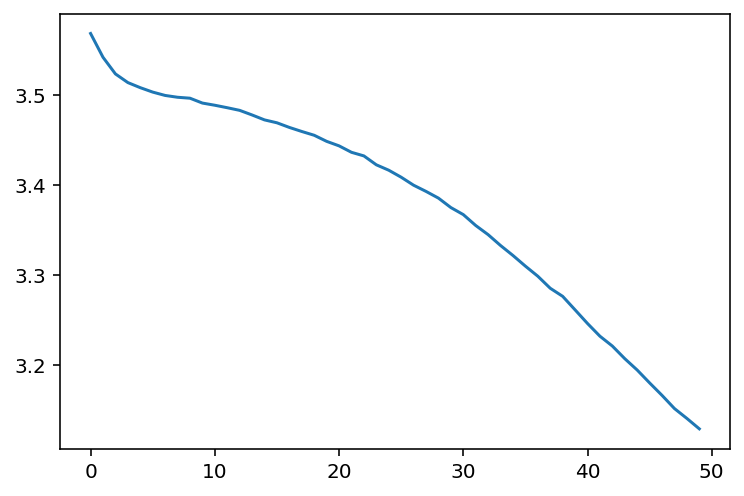

In [13]:
mc = ModelCheckpoint('models/best_model_note.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

device = tf.device('/device:GPU:0') if tf.config.list_physical_devices("GPU") else tf.device('/device:CPU:0')
print(x_tr_note.shape, y_tr_note.shape)
with device:
    history = model_note.fit(x=x_tr_note, y=y_tr_note,
                        batch_size=256, epochs=50, 
                        validation_data=(x_val_note, y_val_note),
                        verbose=1, callbacks=[mc]
    )
plt.plot(history.history['loss'])
plt.show()

In [14]:
inputs = Input((n_timesteps, 1))
x = Dense(128, activation="relu")(inputs)
x = LSTM(128)(x)
x = Dense(128, activation="relu")(x)
output = Dense(len(np.unique(freq_note_strings)), activation="softmax")(x)

model_dur = tf.keras.Model(inputs, output)

model_dur.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model_dur.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8, 1)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 8, 128)            256       
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 40)                5160      
Total params: 153,512
Trainable params: 153,512
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
155/155 [==============================] - 3s 19ms/step - loss: 1.3400 - val_loss: 1.1826

Epoch 00001: val_loss improved from inf to 1.18256, saving model to models/best_model_dur.h5
Epoch 2/50
155/155 [==============================] - 3s 17ms/step - loss: 1.1767 - val_loss: 1.1819

Epoch 00002: val_loss improved from 1.18256 to 1.18194, saving model to models/best_model_dur.h5
Epoch 3/50
155/155 [==============================] - 3s 18ms/step - loss: 1.1710 - val_loss: 1.1722

Epoch 00003: val_loss improved from 1.18194 to 1.17225, saving model to models/best_model_dur.h5
Epoch 4/50
155/155 [==============================] - 3s 18ms/step - loss: 1.1641 - val_loss: 1.1726

Epoch 00004: val_loss did not improve from 1.17225
Epoch 5/50
155/155 [==============================] - 3s 20ms/step - loss: 1.1605 - val_loss: 1.1739

Epoch 00005: val_loss did not improve from 1.17225
Epoch 6/50
155/155 [==============================] - 3s 19ms/step - loss: 1.1585 - val_loss: 1.1675


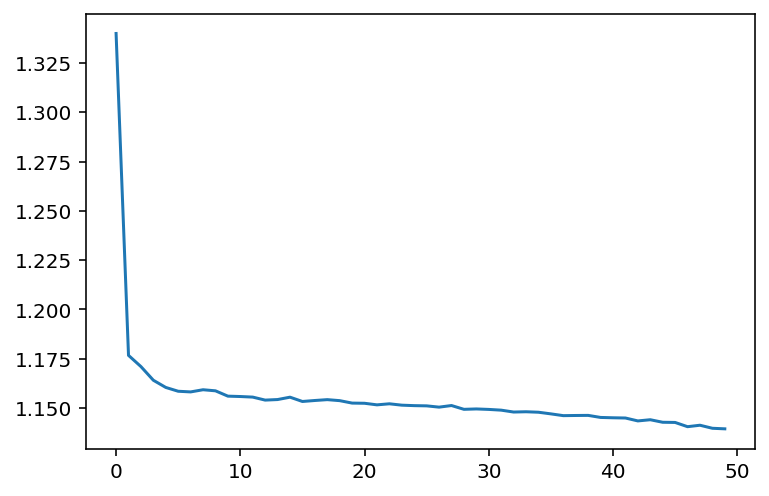

In [15]:
mc = ModelCheckpoint('models/best_model_dur.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

device = tf.device('/device:GPU:0') if tf.config.list_physical_devices("GPU") else tf.device('/device:CPU:0')

with device:
    history = model_dur.fit(x=x_tr_dur, y=y_tr_dur,
                        batch_size=256, epochs=50, 
                        validation_data=(x_val_dur, y_val_dur),
                        verbose=1, callbacks=[mc]
    )
plt.plot(history.history['loss'])
plt.show()

In [16]:
# initial_note_sequence = x_val_note[np.random.randint(0, len(x_val_note))]
# initial_duration_sequence = x_val_dur[np.random.randint(0, len(x_val_dur))]

# feed it a random sequence from the data
initial_note_sequence = x_val_note[np.random.randint(0, len(x_val_note))]
initial_duration_sequence = x_val_dur[np.random.randint(0, len(x_val_dur))]

# x_int_to_note = {v: k for k, v in x_note_to_int.items()}
# x_int_to_dur = {v: k for k, v in x_dur_to_int.items()}

produce_song(initial_note_sequence, initial_duration_sequence, int_to_note, 
                int_to_dur, n_notes=50, midi_file_path="songs/song.mid")

[3, 3, 3, 3, 32, 3, 3, 3, 3, 39, 3, 3, 3, 3, 39, 3, 3, 3, 3, 39, 3, 3, 3, 3, 39, 3, 3, 3, 3, 39, 3, 3, 3, 3, 39, 3, 3, 3, 3, 39, 3, 3, 3, 3, 39, 3, 3, 3, 3, 39]
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
['A3', 'A3', 'A3', 'A3', 'F3', 'A3', 'A3', 'A3', 'A3', 'G5', 'A3', 'A3', 'A3', 'A3', 'G5', 'A3', 'A3', 'A3', 'A3', 'G5', 'A3', 'A3', 'A3', 'A3', 'G5', 'A3', 'A3', 'A3', 'A3', 'G5', 'A3', 'A3', 'A3', 'A3', 'G5', 'A3', 'A3', 'A3', 'A3', 'G5', 'A3', 'A3', 'A3', 'A3', 'G5', 'A3', 'A3', 'A3', 'A3', 'G5']
['quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', 'quarter', '